## Problem Statement

In this problem I have to predict the addiction probability to drugs

In [1]:
#Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from collections import Counter

C:\Users\sngupta\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
sns.set(color_codes= True, palette= 'muted')

pd.options.display.max_columns= 1000
pd.options.display.max_rows= 1000

In [5]:
#Data Reading
train= pd.read_csv('train_file.csv')
test= pd.read_csv('test_file.csv')
sample= pd.read_excel('sample_submission08f968d.xlsx')

In [6]:
train.head(3)

,Patient_ID,YEAR,LocationDesc,Subtopic,Greater_Risk_Question,Description,Sample_Size,Sex,Race,Grade,GeoLocation,QuestionCode,StratID1,StratID2,StratID3,StratificationType,Greater_Risk_Probability
0,1,1995,"Houston, TX",1,Ever used cocaine,"any form of cocaine, such as powder, crack, or...",335.0,Female,Hispanic or Latino,4,"(29.760427, -95.369803)",H49,1,4,0,Local,7.4793
1,2,1997,"Houston, TX",0,Currently drank alcohol,"at least one drink of alcohol, on at least 1 d...",382.0,Total,Black or African American,4,"(29.760427, -95.369803)",H42,0,3,0,Local,49.6852
2,3,1993,Nevada,0,Had their first drink of alcohol before age 13...,other than a few sips,196.0,Female,White,0,"(39.493240390000494, -117.07184056399967)",H41,1,6,2,State,47.8132


In [7]:
#the target is Greate_Risk_Probability
#the data is quit messy, the knowledge of nlp required to solve this problem
#let's check the info of the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55399 entries, 0 to 55398
Data columns (total 17 columns):
Patient_ID                  55399 non-null int64
YEAR                        55399 non-null int64
LocationDesc                55399 non-null object
Subtopic                    55399 non-null int64
Greater_Risk_Question       55399 non-null object
Description                 55399 non-null object
Sample_Size                 55399 non-null float64
Sex                         55399 non-null object
Race                        55399 non-null object
Grade                       55399 non-null int64
GeoLocation                 52098 non-null object
QuestionCode                55399 non-null object
StratID1                    55399 non-null int64
StratID2                    55399 non-null int64
StratID3                    55399 non-null int64
StratificationType          55399 non-null object
Greater_Risk_Probability    55399 non-null float64
dtypes: float64(2), int64(7), object(8)
memory

In [8]:
#there are 55398 data points are present with 17 independent features
#Check for the null values
train.isnull().sum().sort_values(ascending= False)[:2]

GeoLocation                 3301
Greater_Risk_Probability       0
dtype: int64

In [9]:
test.isnull().sum().sort_values(ascending= False)[:2]

GeoLocation           2167
StratificationType       0
dtype: int64

In [10]:
train['GeoLocation'].describe()

count                       52098
unique                         85
top       (40.712784, -74.005941)
freq                         1396
Name: GeoLocation, dtype: object

In [11]:
#Let's check how the target variable is distributed
train['Greater_Risk_Probability'].describe()

count    55399.000000
mean        24.365664
std         20.492551
min          0.000000
25%          8.280050
50%         17.555600
75%         35.430750
max         99.449400
Name: Greater_Risk_Probability, dtype: float64

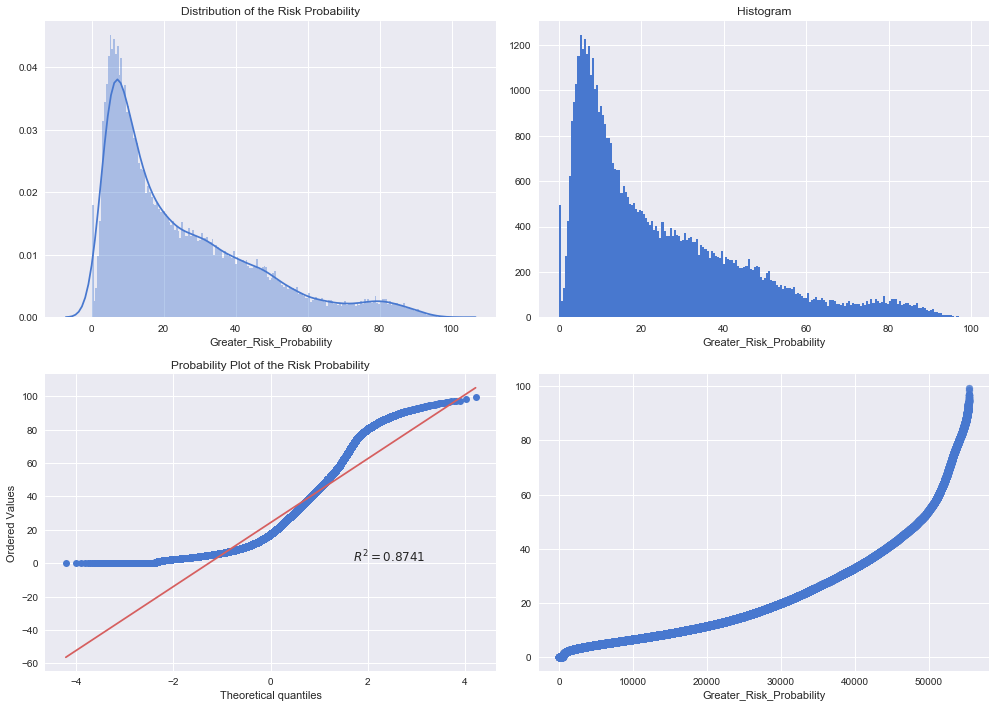

In [12]:
#here, the probability is counted in range(0-100)
plt.figure(figsize= (14, 10))

plt.subplot(221)
sns.distplot(train['Greater_Risk_Probability'], bins= 200)
plt.title('Distribution of the Risk Probability')

plt.subplot(222)
plt.hist(train['Greater_Risk_Probability'], bins= 200)
plt.xlabel('Greater_Risk_Probability')
plt.title('Histogram')

plt.subplot(223)
st.probplot(train['Greater_Risk_Probability'], plot= plt, rvalue= True)
plt.title('Probability Plot of the Risk Probability')

plt.subplot(224)
plt.scatter(train.index, train['Greater_Risk_Probability'].sort_values(), alpha= 0.8)
plt.xlabel('Greater_Risk_Probability')

plt.tight_layout()
plt.show()

In [13]:
#According to the Rick Graph most of the patient are in safe zone because the most of the probbaility lies  closer to 0 and 10

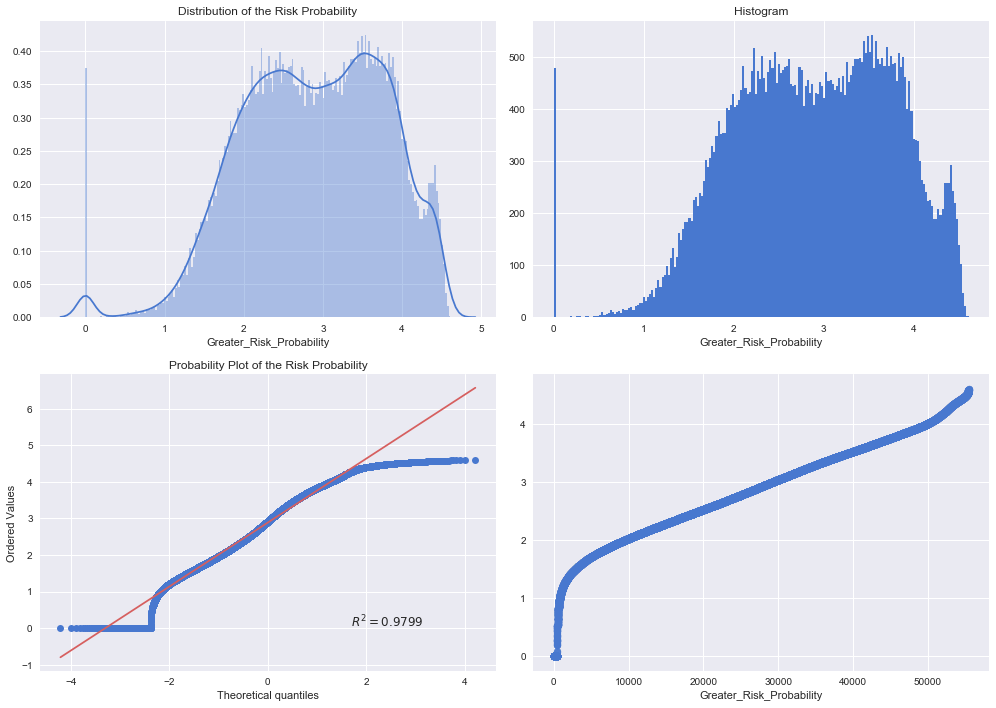

In [14]:
plt.figure(figsize= (14, 10))

plt.subplot(221)
sns.distplot(np.log(train['Greater_Risk_Probability']+1), bins= 200)
plt.title('Distribution of the Risk Probability')

plt.subplot(222)
plt.hist(np.log(train['Greater_Risk_Probability']+1), bins= 200)
plt.xlabel('Greater_Risk_Probability')
plt.title('Histogram')

plt.subplot(223)
st.probplot(np.log(train['Greater_Risk_Probability']+1), plot= plt, rvalue= True)
plt.title('Probability Plot of the Risk Probability')

plt.subplot(224)
plt.scatter(train.index, np.log(train['Greater_Risk_Probability'].sort_values()+1), alpha= 0.8)
plt.xlabel('Greater_Risk_Probability')

plt.tight_layout()
plt.show()

In [15]:
#The probability plot is accurately fit after the log transformation with 0.98 (R2 Value)
#Thus it's better to transform the Risk Probability

In [16]:
for col in list(train):
    print(col, len(train[col].unique()))

Patient_ID 55399
YEAR 14
LocationDesc 91
Subtopic 2
Greater_Risk_Question 20
Description 20
Sample_Size 3583
Sex 3
Race 8
Grade 5
GeoLocation 86
QuestionCode 20
StratID1 3
StratID2 8
StratID3 5
StratificationType 5
Greater_Risk_Probability 51821


In [17]:
train['Description'].unique()

array(['any form of cocaine, such as powder, crack, or freebase, one or more times during their life',
       'at least one drink of alcohol, on at least 1 day during the 30 days before the survey',
       'other than a few sips',
       'pills or shots, one or more times during their life',
       'sniffed glue, breathed the contents of aerosol spray cans, or inhaled any paints or sprays to get high, one or more times during their life',
       'during the 12 months before the survey',
       'also called grass, pot, or weed, one or more times during their life',
       'also called "smack," "junk," or "China White," one or more times during their life',
       'at least one drink of alcohol, on at least 1 day during their life',
       'also called grass, pot, or weed, one or more times during the 30 days before the survey',
       'also called "K2," "Spice," "fake weed," "King Kong," "Yucatan Fire," "Skunk," or "Moon Rocks," one or more times during their life',
       'also called 

In [18]:
#Vectorization is better option than Encoding the respective description

In [19]:
target= train['Greater_Risk_Probability']

In [20]:
train.drop(['Greater_Risk_Probability'], axis= 1, inplace= True)

In [21]:
train['Greater_Risk_Probability']= target

In [22]:
print(train.columns.tolist())

['Patient_ID', 'YEAR', 'LocationDesc', 'Subtopic', 'Greater_Risk_Question', 'Description', 'Sample_Size', 'Sex', 'Race', 'Grade', 'GeoLocation', 'QuestionCode', 'StratID1', 'StratID2', 'StratID3', 'StratificationType', 'Greater_Risk_Probability']


In [23]:
print(test.columns.tolist())

['Patient_ID', 'YEAR', 'LocationDesc', 'Subtopic', 'Greater_Risk_Question', 'Description', 'Sample_Size', 'Sex', 'Race', 'Grade', 'GeoLocation', 'QuestionCode', 'StratID1', 'StratID2', 'StratID3', 'StratificationType']


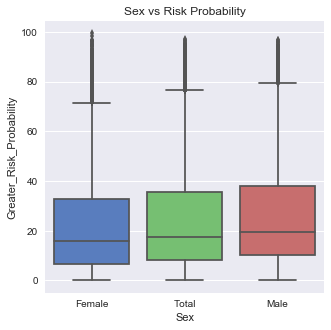

In [24]:
#Let's check how does the Risk varies with  sex
plt.figure(figsize= (5, 5))
sns.boxplot('Sex', 'Greater_Risk_Probability', data= train)
plt.title('Sex vs Risk Probability')
plt.show()

In [25]:
#The average risk in male is greater than female and total.

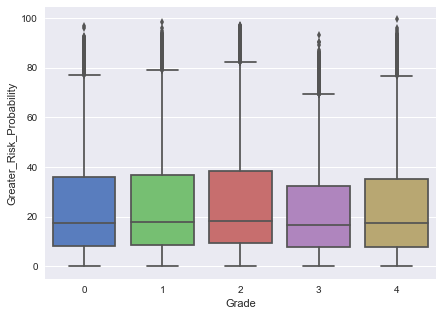

In [26]:
plt.figure(figsize= (7, 5))
sns.boxplot('Grade', 'Greater_Risk_Probability', data= train)
plt.show()

In [28]:
train['latitude']= np.nan
train['longitude']= np.nan

In [38]:
for geoloc in train['GeoLocation'].unique():
    
    try:
        
        mask= (train['GeoLocation']== geoloc)

        geoloc= str(geoloc).replace('(', '')
        geoloc= geoloc.replace(')', '')

        split= str(geoloc).split(',')
        lat= float(split[0])
        lon= float(split[1])

        #lat= str(lat).replace('(', '')
        #lat= float(lat)

        #lon= str(lon).replace(')', '')
        #lon= float(lon)

        train.loc[mask, 'latitude']= lat
        train.loc[mask, 'longitude']= lon
        
    except:
        pass

In [41]:
for geoloc in test['GeoLocation'].unique():
    
    try:
        
        mask= (test['GeoLocation']== geoloc)

        geoloc= str(geoloc).replace('(', '')
        geoloc= geoloc.replace(')', '')

        split= str(geoloc).split(',')
        lat= float(split[0])
        lon= float(split[1])

        #lat= str(lat).replace('(', '')
        #lat= float(lat)

        #lon= str(lon).replace(')', '')
        #lon= float(lon)

        test.loc[mask, 'latitude']= lat
        test.loc[mask, 'longitude']= lon
        
    except:
        pass

In [44]:
cat_var= [var for var in list(train) if train[var].dtypes== 'O']

In [46]:
cat_var.remove('GeoLocation')

In [47]:
from sklearn.preprocessing import LabelEncoder

In [48]:
for var in cat_var:
    encoder= LabelEncoder().fit(train[var])
    train[var]= encoder.transform(train[var].astype(str))
    test[var]= encoder.transform(test[var].astype(str))

In [49]:
train_= train.copy()
test_= test.copy()

In [50]:
train.head(2)

,Patient_ID,YEAR,LocationDesc,Subtopic,Greater_Risk_Question,Description,Sample_Size,Sex,Race,Grade,GeoLocation,QuestionCode,StratID1,StratID2,StratID3,StratificationType,Greater_Risk_Probability,latitude,longitude
0,1,1995,32,1,6,7,335.0,0,3,4,"(29.760427, -95.369803)",9,1,4,0,0,7.4793,29.760427,-95.369803
1,2,1997,32,0,0,8,382.0,2,2,4,"(29.760427, -95.369803)",2,0,3,0,0,49.6852,29.760427,-95.369803


In [51]:
train.drop(['Patient_ID', 'GeoLocation', 'Greater_Risk_Probability'], axis= 1, inplace= True)
test.drop(['Patient_ID', 'GeoLocation'], axis= 1, inplace= True)

In [53]:
#It is a problem Regression
target= np.log(target+1)

In [54]:
import catboost as cb
from sklearn.model_selection import KFold

In [55]:
cat_feat_index_= np.where(train.dtypes!= np.float)[0]

In [56]:
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

In [61]:
def run_CB(train, target, test, cat_feat_index= cat_feat_index_):
    #from sklearn.model_selection import train_test_split
    from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
    #X_train, X_test, y_train, y_test= train_test_split(train, target, random_state= 0)
    
    r_squared_1= []
    mse_1= []
    rmse_1= []
    rmsle_1= []
    y_test_1= []
    #msle_1= []
    
    kf = KFold(n_splits=5, shuffle= True, random_state= 2019) 

    for train_index, test_index in kf.split(train, target):
        #print("Train:", train_index, "Validation:",test_index)
        X_train, X_test = train.loc[train_index,:], train.loc[test_index,:] 
        y_train, y_test = target[train_index], target[test_index]
    
        param_cb= {}
        param_cb['iterations']= 10000
        param_cb['learning_rate']= 0.1
        #param_cb['max_depth']= 3
        param_cb['random_seed']= 2019

        model= cb.CatBoostRegressor(**param_cb)

        #model.fit(X_train, y_train, cat_feat_index, eval_set= (X_test, y_test), early_stopping_rounds= 50, verbose= 1000)
        model.fit(X_train, y_train, cat_feat_index, eval_set= (X_test, y_test), verbose= 100, early_stopping_rounds= 50)


        y_pred= model.predict(X_test)
        #y_pred_1.append(y_pred)
        y_test_= model.predict(test)
        y_test_1.append(y_test_)
        
        r_squared= r2_score(y_test, y_pred)
        mse= mean_squared_error(y_test, y_pred)
        rmse= np.sqrt(mse)
        msle= mean_squared_log_error(y_test, y_pred)
        rmsle= np.sqrt(msle)
        
        r_squared_1.append(r_squared)
        mse_1.append(mse)
        rmse_1.append(rmse)
        rmsle_1.append(rmsle)
        #msle_1.append(msle)
    print('The R-Squared value: {:.4f}' .format(np.mean(r_squared_1)))
    print('Mean Squared Error: {:.4f}' .format(np.mean(mse_1)))
    print('Root Mean Squared Error: {:.4f}' .format(np.mean(rmse_1)))
    print('Root Mean Squared Log Error: {:.4f}' .format(np.mean(rmsle_1)))

    return np.mean(y_test_1, axis= 0)

In [62]:
pred_cb_1= run_CB(train, target, test)

0:	learn: 2.7375094	test: 2.7374550	best: 2.7374550 (0)	total: 62.8ms	remaining: 10m 27s
100:	learn: 0.3661165	test: 0.3580523	best: 0.3580522 (98)	total: 18.9s	remaining: 30m 54s
200:	learn: 0.3484664	test: 0.3404529	best: 0.3404529 (199)	total: 44.4s	remaining: 36m 5s
300:	learn: 0.3389024	test: 0.3313925	best: 0.3313925 (300)	total: 1m 8s	remaining: 36m 36s
400:	learn: 0.3324314	test: 0.3259654	best: 0.3259654 (400)	total: 1m 37s	remaining: 38m 47s
500:	learn: 0.3288882	test: 0.3226914	best: 0.3226914 (500)	total: 1m 58s	remaining: 37m 24s
600:	learn: 0.3247105	test: 0.3194717	best: 0.3194717 (600)	total: 2m 19s	remaining: 36m 27s
700:	learn: 0.3207425	test: 0.3164690	best: 0.3164690 (700)	total: 2m 42s	remaining: 35m 55s
800:	learn: 0.3183330	test: 0.3147759	best: 0.3147759 (800)	total: 3m 4s	remaining: 35m 17s
900:	learn: 0.3168487	test: 0.3137948	best: 0.3137948 (899)	total: 3m 32s	remaining: 35m 48s
1000:	learn: 0.3139319	test: 0.3118076	best: 0.3118076 (1000)	total: 4m 2s	remai

In [64]:
pred_cb_2= np.exp(pred_cb_1)

In [65]:
pred_cb_2

array([56.84222424, 31.70892767, 46.16853863, ..., 16.83210112,
        4.5331452 , 62.07473784])

In [67]:
sample.shape, test.shape

((5, 2), (36932, 16))

In [78]:
sample_1= test_[['Patient_ID']]

In [80]:
sample_1['Greate_Risk_Probability']= pred_cb_2

In [82]:
sample.head()

,Patient_ID,Greater_Risk_Probability
0,212114,19.9652
1,212115,70.4790
2,212116,22.5626
3,212117,37.4393
4,212118,35.3642


In [84]:
sample_1.rename(columns={'Greate_Risk_Probability': 'Greater_Risk_Probability'}, inplace= True)

In [85]:
sample_1.head()

,Patient_ID,Greater_Risk_Probability
0,55400,56.842224
1,55401,31.708928
2,55402,46.168539
3,55403,19.316248
4,55404,7.435873


In [86]:
sample_1.to_csv('sample_1.csv', index= False)